In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   
from sklearn.preprocessing import MinMaxScaler

2023-05-22 04:05:49.454689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 04:05:49.454721: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
    
    
    data = dataframe
    # Kolom yang akan dinormalisasi
    columns_to_normalize = ["Jarak pusat kota2", "Visibilitas", "Bangunan", "Luas"]

    # Membuat Min-Max Scaler
    scaler = MinMaxScaler(feature_range=(0, 10))
    
    
    # Melakukan normalisasi pada kolom yang diinginkan
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

    # Menggabungkan kolom peruntukan dengan data yang sudah dinormalisasi
    result = pd.concat([data["Peruntukan"], data[columns_to_normalize]], axis=1)

    dataframe = data

    
    #dataframe = dataframe.copy()
    labels = dataframe.pop('Peruntukan')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)
    #normalizer = tf.keras.layers.experimental.preprocessing.MinMaxNormalization(min_value=0, max_value=10)

    
    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    
    return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_340322/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_340322/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_340322/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_340322/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_340322/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 21ms/step - loss: 1.7750 - accuracy: 0.2041 - val_loss: 1.6923 - val_accuracy: 0.2778
Epoch 2/150
13/13 [==============================] - 0s 8ms/step - loss: 1.6361 - accuracy: 0.2857 - val_loss: 1.6571 - val_accuracy: 0.3889
Epoch 3/150
13/13 [==============================] - 0s 5ms/step - loss: 1.6991 - accuracy: 0.4082 - val_loss: 1.6235 - val_accuracy: 0.3889
Epoch 4/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7081 - accuracy: 0.2653 - val_loss: 1.5909 - val_accuracy: 0.4074
Epoch 5/150
13/13 [==============================] - 0s 5ms/step - loss: 1.6702 - accuracy: 0.4490 - val_loss: 1.5626 - val_accuracy: 0.4074
Epoch 6/150
13/13 [==============================] - 0s 5ms/step - loss: 1.5183 - accuracy: 0.3673 - val_loss: 1.5348 - val_accuracy: 0.4074
Epoch 7/150
13/13 [==============================] - 0s 7ms/step - loss: 1.4498 - accuracy: 0.5510 - val_loss: 1.5083 - val_accuracy: 0.4630
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7839 - accuracy: 0.7551 - val_loss: 0.7515 - val_accuracy: 0.6852
Epoch 60/150
13/13 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.7551 - val_loss: 0.7427 - val_accuracy: 0.6852
Epoch 61/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7528 - accuracy: 0.7143 - val_loss: 0.7360 - val_accuracy: 0.6852
Epoch 62/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7482 - accuracy: 0.7143 - val_loss: 0.7290 - val_accuracy: 0.6852
Epoch 63/150
13/13 [==============================] - 0s 4ms/step - loss: 0.7164 - accuracy: 0.7959 - val_loss: 0.7220 - val_accuracy: 0.6852
Epoch 64/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7712 - accuracy: 0.6327 - val_loss: 0.7154 - val_accuracy: 0.6852
Epoch 65/150
13/13 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.7347 - val_loss: 0.7073 - val_accuracy: 0.6852
Epoch 

13/13 [==============================] - 0s 5ms/step - loss: 0.3981 - accuracy: 0.8980 - val_loss: 0.5317 - val_accuracy: 0.7593
Epoch 117/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4643 - accuracy: 0.8163 - val_loss: 0.5294 - val_accuracy: 0.7593
Epoch 118/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5095 - accuracy: 0.7551 - val_loss: 0.5266 - val_accuracy: 0.7593
Epoch 119/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4723 - accuracy: 0.8367 - val_loss: 0.5231 - val_accuracy: 0.7593
Epoch 120/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4659 - accuracy: 0.8571 - val_loss: 0.5234 - val_accuracy: 0.7593
Epoch 121/150
13/13 [==============================] - 0s 6ms/step - loss: 0.4625 - accuracy: 0.8571 - val_loss: 0.5222 - val_accuracy: 0.7593
Epoch 122/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5723 - accuracy: 0.7347 - val_loss: 0.5212 - val_accuracy: 0.7593
Epoch 123/150

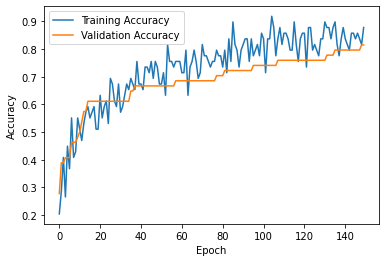

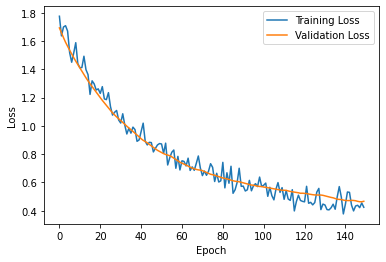

Best validation accuracy: 0.8148148059844971
Training accuracy at the best test accuracy: 0.8163265585899353


AttributeError: 'DataFrame' object has no attribute 'Peruntukan'

In [14]:
run_model(ratio_1, callback_1)

In [ ]:
run_model(ratio_2, callback_2)

In [ ]:
run_model(ratio_3, callback_3)

In [ ]:
run_model(ratio_4, callback_4)

In [ ]:
run_model(ratio_5, callback_5)

In [ ]:
def encoded_debug(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

# DEBUGGER

In [ ]:
def debug_normalization(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    print("print traind ds")
    print(train_ds)
    encoded_debug(train_ds)

In [ ]:
debug_normalization(ratio_1, callback_1)

In [ ]:
train_ds

# Decision Tree algorithm

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset into a pandas DataFrame
data =  pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")
data = data[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
data = change_categorical_to_number(data)

df = data


# Split the dataset into features (X) and target (y)
X = df.drop('Peruntukan', axis=1)  # Features
y = df['Peruntukan']  # Target

# Convert categorical labels to numerical labels
y = pd.factorize(y)[0]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# Create a Random Forest Classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=150)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset into a pandas DataFrame

# Load your dataset into a pandas DataFrame
data =  pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")
data = data[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
data = change_categorical_to_number(data)

df = data


# Split the dataset into features (X) and target (y)
X = df.drop('Peruntukan', axis=1)  # Features
y = df['Peruntukan']  # Target

# Convert categorical labels to numerical labels
y = pd.factorize(y)[0]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


In [ ]:
from sklearn.tree import export_text

r = export_text(dt_classifier, feature_names= ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"])
print(r)

# CROW SEARCH OPTIMISASI ALGORITHM

In [ ]:
import numpy as np

# Define the CSO algorithm
def cso_algorithm(X, y, num_crows, max_iterations):
    num_features = X.shape[1]
    num_classes = len(np.unique(y))
    
    # Initialize the positions and fitness of crows
    positions = np.random.uniform(size=(num_crows, num_features))
    fitness = np.zeros(num_crows)
    
    # Main loop
    for iteration in range(max_iterations):
        # Evaluate the fitness of each crow
        for i in range(num_crows):
            # Decode the positions to obtain the solutions
            solutions = decode_solutions(positions[i], num_classes)
            
            # Calculate the fitness based on the solutions
            fitness[i] = evaluate_fitness(X, y, solutions)
        
        # Find the best crow
        best_crow = np.argmin(fitness)
        
        # Update the positions of crows
        for i in range(num_crows):
            # Move the crow towards the best crow
            positions[i] = move_crow(positions[i], positions[best_crow])
            
            # Perform crossover operation between crows
            positions[i] = crossover(positions[i], positions[np.random.choice(num_crows)])
    
    # Decode the solutions of the best crow
    best_solutions = decode_solutions(positions[best_crow], num_classes)
    
    return best_solutions

# Helper functions

def decode_solutions(position, num_classes):
    # Decode the position to obtain the solutions
    threshold = np.linspace(0, 1, num_classes + 1)
    solutions = np.zeros(num_classes)
    
    for i in range(num_classes):
        solutions[i] = np.sum((position >= threshold[i]) & (position < threshold[i+1]))
    
    return solutions

def evaluate_fitness(X, y, solutions):
    # Implement your own fitness evaluation function based on the solutions
    # This can be done by training a classifier using the solutions and evaluating its performance
    # Return the fitness value, such as accuracy or any other suitable metric
    pass

def move_crow(crow_position, best_crow_position):
    # Implement the movement operation to update the crow's position
    # This can be done by adjusting the crow's position based on the best crow's position and a movement step size
    # Return the updated crow's position
    pass

def crossover(crow1_position, crow2_position):
    # Implement the crossover operation to create a new crow position
    # This can be done by combining the positions of two crows in a specific way
    # Return the new crow position
    pass

# Usage example

# Assuming you have your input data X and target labels y ready

# Set the parameters
num_crows = 50
max_iterations = 100

# Load your dataset into a pandas DataFrame
data =  pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")
data = data[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
data = change_categorical_to_number(data)

df = data


# Split the dataset into features (X) and target (y)
X = df.drop('Peruntukan', axis=1)  # Features
y = df['Peruntukan']  # Target


# Apply the CSO algorithm
best_solutions = cso_algorithm(X, y, num_crows, max_iterations)

# Print the best solutions obtained
print("Best solutions:", best_solutions)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your data into a pandas DataFrame
data =  pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")
data = data[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
data = change_categorical_to_number(data)

df = data

# Assuming 'Peruntukan' is the column name containing the labels
labels = df['Peruntukan']

# Encode labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Drop the 'Peruntukan' column and use the remaining columns as features
X = df.drop('Peruntukan', axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CSO algorithm
def cso_algorithm(X, y, num_crows, max_iterations):
    num_features = X.shape[1]
    num_classes = len(np.unique(y))
    
    # Initialize the positions and fitness of crows
    positions = np.random.uniform(size=(num_crows, num_features))
    fitness = np.zeros(num_crows)
    
    # Main loop
    for iteration in range(max_iterations):
        # Evaluate the fitness of each crow
        for i in range(num_crows):
            # Decode the positions to obtain the solutions
            solutions = decode_solutions(positions[i], num_classes)
            
            # Calculate the fitness based on the solutions
            fitness[i] = evaluate_fitness(X, y, solutions)
        
        # Find the best crow
        best_crow = np.argmin(fitness)
        
        # Update the positions of crows
        for i in range(num_crows):
            # Move the crow towards the best crow
            positions[i] = move_crow(positions[i], positions[best_crow])
            
            # Perform crossover operation between crows
            positions[i] = crossover(positions[i], positions[np.random.choice(num_crows)])
    
    # Decode the solutions of the best crow
    best_solutions = decode_solutions(positions[best_crow], num_classes)
    
    return best_solutions

# Helper functions

def decode_solutions(position, num_classes):
    # Decode the position to obtain the solutions
    threshold = np.linspace(0, 1, num_classes + 1)
    solutions = np.zeros(num_classes)
    
    for i in range(num_classes):
        solutions[i] = np.sum((position >= threshold[i]) & (position < threshold[i+1]))
    
    return solutions

def evaluate_fitness(X, y, solutions):
    # Implement your own fitness evaluation function based on the solutions
    # This can be done by training a classifier using the solutions and evaluating its performance
    # Return the fitness value, such as accuracy or any other suitable metric
    pass

def move_crow(crow_position, best_crow_position):
    # Implement the movement operation to update the crow's position
    # This can be done by adjusting the crow's position based on the best crow's position and a movement step size
    # Return the updated crow's position
    pass

def crossover(crow1_position, crow2_position):
    # Implement the crossover operation to create a new crow position
    # This can be done by combining the positions of two crows in a specific way
    # Return the new crow position
    pass

# Set the parameters
num_crows = 50
max_iterations = 100

# Apply the CSO algorithm
best_solutions = cso_algorithm(X_train, y_train, num_crows, max_iterations)

# Print the best solutions obtained
print("Best solutions:", best_solutions)


In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from CSO import CSO

# Load the iris dataset as an example
iris = load_iris()
X, y = iris.data, iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classification function
def classify(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Define the fitness function for CSO
def fitness_function(position):
    clf = SVC(C=position[0], gamma=position[1])
    return 1 - classify(X_train, y_train, X_test, y_test, clf)

# Define the number of dimensions (hyperparameters)
num_dimensions = 2

# Define the number of crows (population size)
num_crows = 10

# Define the maximum number of iterations
max_iter = 100

# Create an instance of CSO and run the optimization
cso = CSO(fitness_function, num_dimensions, num_crows)
best_position, best_fitness = cso.run(max_iter)

# Print the best hyperparameters and accuracy
print("Best C value:", best_position[0])
print("Best gamma value:", best_position[1])
print("Best accuracy:", 1 - best_fitness)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")




tree_feeding = data[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(data, iris.target)


# Confusion Matriks

In [ ]:
def matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = tf.keras.models.load_model(best_model)

    # Ubah output prediksi menjadi label kelas
    label_kelas = ['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)

    print('Best validation accuracy:', max(model.history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

In [ ]:
matrix("./50.h5")
matrix("./40.h5")
con("./30.h5")
confusion_matrix("./20.h5")
confusion_matrix("./10.h5")

In [ ]:
confusion_matrix = cm

true_positives = np.diagonal(confusion_matrix)

# Step 3: Calculate the accuracy percentage for each class
class_totals = np.sum(confusion_matrix, axis=1)
class_accuracies = true_positives / class_totals * 100

# Step 4: Calculate the overall accuracy percentage
total_instances = np.sum(confusion_matrix)
overall_accuracy = np.sum(true_positives) / total_instances * 100

# Step 5: Calculate the total data instances for each class
class_data_totals = np.sum(confusion_matrix, axis=0)

# Print the results
print("True Positives for each class:", true_positives)
print("Total Data Instances for each class:", class_data_totals)
print("Overall Accuracy Percentage:", overall_accuracy)

In [ ]:
true_positives = np.diagonal(confusion_matrix)

# Step 3: Calculate the accuracy percentage for each class
class_data_totals = np.sum(confusion_matrix, axis=0)
class_accuracies = true_positives / class_data_totals * 100

# Step 4: Calculate the overall accuracy percentage
total_instances = np.sum(confusion_matrix)
overall_accuracy = np.sum(true_positives) / total_instances * 100

# Print the results
print("Accuracy for each label:", class_accuracies)
print("True Positives for each class:", true_positives)
print("Total Data Instances for each class:", class_data_totals)
print("Overall Accuracy Percentage:", overall_accuracy)

In [ ]:
for label, accuracy in zip(label_kelas, class_accuracies):
    print("Accuracy for", label, ":", accuracy)
    

In [ ]:
true_positives = np.diagonal(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Step 3: Calculate precision, recall, and F1 score for each label
accuracy = true_positives / np.sum(confusion_matrix, axis=1)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Step 4: Calculate the total accuracy
total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100

# Print the results
print("Accuracy for each label:", class_accuracies)
print("Precision for each label:", precision)
print("Recall for each label:", recall)
print("F1 Score for each label:", f1_score)
print("Total Accuracy:", total_accuracy)

In [ ]:
true_positives = np.diagonal(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Step 3: Calculate precision, recall, and F1 score for each label
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Step 4: Calculate the total accuracy
total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100

# Print the results
print("True Positives for each label:", true_positives)
print("total classes",class_data_totals)
print("tp+fp pembagi precision",true_positives + false_positives )
print("tp+fn pembagi recall",true_positives + false_negatives )
print("f1 p kali r", (precision * recall))

In [ ]:
max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

# Get the corresponding training accuracy
training_accuracy = history.history['accuracy'][max_test_accuracy_index]

print('Best validation accuracy:', max(history.history['val_accuracy']))
print('Training accuracy at the best test accuracy:', training_accuracy)

In [ ]:
model.predict(val_ds)

In [ ]:
import numpy as np

y_pred = model.predict(val_ds)

         #   test.Peruntukan == "Pasar",
          #   test.Peruntukan == "Kantor",
           #  test.Peruntukan == "Ruko",
            # test.Peruntukan == "Taman",
             #test.Peruntukan == "Perumahan",
             #test.Peruntukan == "Sawah",
            
         #   value = [5,4,3,2,1,0]
y_pred



In [ ]:
val_ds

In [ ]:
# Ubah output prediksi menjadi label kelas
label_kelas = ['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']
y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

# Tampilkan hasil prediksi
print(y_pred_label)

In [ ]:
for x in y_pred_label:
    print(x)